In [2]:
# Import packages
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from mlxtend.plotting import plot_decision_regions
import random
from sklearn.model_selection import train_test_split

In [3]:
# Read csv for training data, may need to mount gdrive beforehand if loading directly from drive. 
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Discriminants/Training Scripts for Paper/training_data.csv')

In [4]:
#split the train and test set and encode it as one-hot vectors. 
df_features = df[['a', 'b']]
df_labels = df[['No. Real Roots']]

train_features, test_features, train_labels, test_labels = train_test_split(df_features, df_labels, train_size=0.5, test_size=0.5, random_state=0)

ohe = sklearn.preprocessing.OneHotEncoder()

train_labels_onehot = ohe.fit_transform(train_labels).toarray()
test_labels_onehot = ohe.fit_transform(test_labels).toarray()

train_features = pd.DataFrame(train_features).values
train_labels_onehot = pd.DataFrame(train_labels_onehot).values
test_features = pd.DataFrame(test_features).values
test_labels_onehot = pd.DataFrame(test_labels_onehot).values

train_features = torch.tensor(train_features, dtype=torch.float32)
train_labels_onehot = torch.tensor(train_labels_onehot, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_labels_onehot = torch.tensor(test_labels_onehot, dtype=torch.float32)

In [22]:
# define polynomial activations with default degree 2. 
class PolynomialActivation(nn.Module):
    def __init__(self, degree=2):
        super().__init__()
        self.degree = degree

    def forward(self, x):
        return x ** self.degree

# Define the neural network. In this case we are considering width 20 and depth 5 fully quadratic neural networks. 
class Net(nn.Module):
    def __init__(self, degree=2):
        super().__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 2)
        self.poly_activation = PolynomialActivation(degree)

    def forward(self, x):
        x = self.poly_activation(self.fc1(x))
        x = self.poly_activation(self.fc2(x)) # if we want the semi-quadratic case, all other layers would call self.fcX(x) instead of going through the self.poly_activation. 
        x = self.poly_activation(self.fc3(x))
        x = self.poly_activation(self.fc4(x))
        x = self.poly_activation(self.fc5(x))
        #x = F.softmax(self.fc4(x), dim=1) # For softmax activation
        return x

model = Net(degree=2)

In [167]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0.001) # Use SGD

# Train the model over 60 epochs
for epoch in range(60):
    running_loss = 0.0
    for i in range(0, len(train_features), 256):
        inputs = train_features[i:i+256]
        labels = torch.argmax(train_labels_onehot[i:i+256], dim=1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Epoch [{}/40], Loss: {:.4f}'.format(epoch+1, running_loss))

Epoch [1/40], Loss: 6.5805
Epoch [2/40], Loss: 10483253273.0655
Epoch [3/40], Loss: 1266206209418624761856.0000
Epoch [4/40], Loss: 2575.3227
Epoch [5/40], Loss: 2575.3227
Epoch [6/40], Loss: 2575.3227
Epoch [7/40], Loss: 2575.3227
Epoch [8/40], Loss: 2575.3227
Epoch [9/40], Loss: 2575.3227
Epoch [10/40], Loss: 2575.3227
Epoch [11/40], Loss: 2575.3227
Epoch [12/40], Loss: 2575.3227
Epoch [13/40], Loss: 2575.3227
Epoch [14/40], Loss: 2575.3227
Epoch [15/40], Loss: 2575.3227
Epoch [16/40], Loss: 2575.3227
Epoch [17/40], Loss: 2575.3226
Epoch [18/40], Loss: 2575.1714
Epoch [19/40], Loss: 2574.5105
Epoch [20/40], Loss: 2572.5180
Epoch [21/40], Loss: 2566.6685
Epoch [22/40], Loss: 2551.3141
Epoch [23/40], Loss: 2510.9182
Epoch [24/40], Loss: 2407.8878
Epoch [25/40], Loss: 2164.4335
Epoch [26/40], Loss: 1694.2892
Epoch [27/40], Loss: 1115.0749
Epoch [28/40], Loss: 739.1698
Epoch [29/40], Loss: 634.4270
Epoch [30/40], Loss: 623.3624
Epoch [31/40], Loss: 620.7900
Epoch [32/40], Loss: 618.1239


In [169]:
# Extract the weights and biases of the trained model. 
fc1_weights = model.fc1.weight.detach()
fc1_bias = model.fc1.bias.detach()

fc2_weights = model.fc2.weight.detach()
fc2_bias = model.fc2.bias.detach()

fc3_weights = model.fc3.weight.detach()
fc3_bias = model.fc3.bias.detach()

fc4_weights = model.fc4.weight.detach()
fc4_bias = model.fc4.bias.detach()

fc5_weights = model.fc5.weight.detach()
fc5_bias = model.fc5.bias.detach()

In [170]:
def polynomial_activation(x, degree=2):
    return x ** degree

# Reconstruct the neural net as a function by making the appropriate linear transformations and passing through activation functions. 
def neural_net(x):
  # Calculate the output of the first layer
  fc1_output = torch.matmul(x, fc1_weights.T) + fc1_bias
  # Apply ReLU activation function to the output of the first layer
  fc1_output = polynomial_activation(fc1_output)
        
  # Calculate the output of the second layer
  fc2_output = torch.matmul(fc1_output, fc2_weights.T) + fc2_bias
  # Apply ReLU activation function to the output of the second layer
  fc2_output = polynomial_activation(fc2_output)
        
  # Calculate the output of the third layer
  fc3_output = torch.matmul(fc2_output, fc3_weights.T) + fc3_bias
  fc3_output = polynomial_activation(fc3_output)

  # Calculate the output of the forth layer
  fc4_output = torch.matmul(fc3_output, fc4_weights.T) + fc4_bias
  fc4_output = polynomial_activation(fc4_output)

  # Calculate the output of the fifth layer
  fc5_output = torch.matmul(fc4_output, fc5_weights.T) + fc5_bias
        
  # Apply softmax activation function to the output of the final layer
  #x = F.softmax(fc4_output, dim=1)
  x = polynomial_activation(fc5_output)
        
  return x

In [171]:
# Return the difference bewteen the first and second entry of the neural network's 2-entry vector output. 
def fct_diff(x,y):
  return np.squeeze(neural_net(torch.tensor([[float(x),float(y)]])).detach().numpy()) @ np.array([-1,1])

In [172]:
# Find n points (x,y) in [-1,1]^2, a subset of RR^2, where fct_diff(x,y)=0. 
def find_zeroes(n):
  table = []
  i=0
  while i <= n:
    a = random.uniform(-1,1) # first pick a  random x-coordinate which we call a

    def fct_a(x):
      return fct_diff(a, x) # for fixed coordinate define a new univariate function in terms of x
    
    b = scipy.optimize.root(fct_a, random.unifomr(-1,1), method='lm') # find the root of the univariate polynomial. 

    entry = [a, float(b.x)] # Create the entry [a,b] where fct_diff(a,b)=0

    table.append(entry) # append it to the list

    i += 1

  return pd.DataFrame(table, columns=['a', 'b'])

In [173]:
interpolate = find_zeroes(200) # Find 200 zeroes where 

In [174]:
import scipy.integrate
import scipy.optimize

# given two continuous functions f,g on the closed interval [a,b], this computes the integral between a and b of |f(x)-g(x)|. 
def int_diff(f,g,a,b):
  return scipy.integrate.quad(lambda x: abs(f(x)-g(x)), a, b)

In [175]:
def create_polynomial(v):
    """
    Create a polynomial function from a vector of coefficients.
    """
    p = np.poly1d(v)
    def poly(x):
        return p(x)
    return poly

In [176]:
# Defines the true discriminant as a function. 
def true_disc(x):
  return 0.25*x**2

In [177]:
# interpolates a given set of points [interpolate], and returns a dataframe of degree-MSE error pairs. We would pick the lowest degree when the error stabilizes. 
def degree_interpolation(n):
  err_deg = []
  for i in range(1,n+1):
    coeffs, residuals, _, _, _ = np.polyfit(interpolate.iloc[:,0], interpolate.iloc[:,1], deg=i, full=True)
    err_val = residuals[0]
    err_deg.append([i, err_val])
  return pd.DataFrame(err_deg)

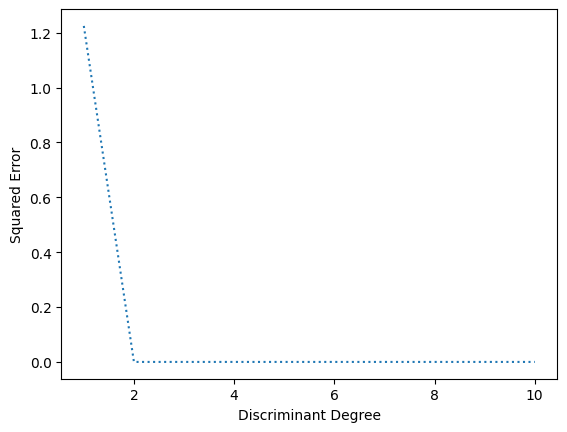

In [178]:
# Plot the degree_interpolations values. As expected, interpolating with polynommials of degree >=2 do not improve the error, so we expect the polynomial we wish to approximate to be degree 2. 
err_vals = degree_interpolation(10)

plt.plot(err_vals.iloc[:,0], err_vals.iloc[:,1], linestyle = 'dotted')
plt.xlabel("Discriminant Degree")
plt.ylabel("Squared Error")
plt.show()

In [179]:
# From the above, we pick degree 2 and return the coefficient list of the best-fit polynomial. 
poly_coeffs = np.polyfit(interpolate.iloc[:,0], interpolate.iloc[:,1], deg=2)
poly_coeffs

array([ 2.49910903e-01, -3.02311629e-04,  9.37752119e-06])

In [180]:
# create the predicted discriminant from the list of coefficients in the tuple. 
def pred_disc(x):
  return poly_coeffs[0]*x**2 + poly_coeffs[1]*x + poly_coeffs[2]

In [181]:
# Evaluate the model accuracy on the test set
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(test_features)):
        inputs = test_features[i].unsqueeze(0)
        labels = torch.argmax(test_labels_onehot[i])

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test set: {:.2f}%'.format(100 * correct / total))

Accuracy of the network on the test set: 99.04%


In [182]:
# Evaluate the integral difference as defined by the int_diff function above. This will be the integral of |f(x)-D(x)| where f(x) is the predicted discriminant and D(x) is the true discriminant. 
int_diff(true_disc, pred_disc, -1, 1)

(0.0003026007663843327, 6.877539359748378e-10)